In [31]:
import lifetimes
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from lifetimes import BetaGeoFitter # BG/NBD
from lifetimes import GammaGammaFitter # Gamma-Gamma Model
from lifetimes.plotting import plot_frequency_recency_matrix

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [32]:
orders_df = pd.read_csv(r'/Users/matefer2006/Downloads/CLV Project query_08202024 (Github).csv')

In [33]:
orders_df.head()

,ACCOUNT_ID,PRODUCT,ORDER_DATE,LAST_ORDERDATE,TIME_BETWEEN_ORDERS,REVENUE,QUANTITY
0,83815.00,Prod2,15/09/2023,NaN,NaN,6300,15
1,22625.00,Prod1,17/08/2020,NaN,NaN,4680,12
2,22625.00,Prod1,03/09/2020,17/08/2020,17.00,5000,10
3,22625.00,Prod1,14/09/2020,03/09/2020,11.00,5000,10
4,22625.00,Prod1,22/09/2020,14/09/2020,8.00,9750,25


### Data cleansing, removing outliers - top 1% quantile

In [34]:
orders_df.describe()

,ACCOUNT_ID,TIME_BETWEEN_ORDERS,REVENUE,QUANTITY
count,76064.00,58748.00,76123.00,76123.00
mean,50421.46,79.81,7922.09,20.46
std,29006.99,95.97,31397.69,54.75
min,10.00,1.00,0.00,0.00
25%,25149.00,21.00,3600.00,10.00
50%,50607.00,49.00,5850.00,15.00
75%,75501.00,98.00,9750.00,25.00
max,99985.00,1334.00,3840000.00,6400.00


In [35]:
orders_df['ORDER_DATE'] = pd.to_datetime(orders_df['ORDER_DATE'])

/var/folders/ny/28gsz9k14y592crfr9t1v3x00000gn/T/ipykernel_43983/2858039207.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  orders_df['ORDER_DATE'] = pd.to_datetime(orders_df['ORDER_DATE'])


Comment this section if we don't want to exclude anything

In [36]:
def quantiles(df, variable, q1=0.01, q2=0.99):
    lower_boundary = df[variable].quantile(q1)
    upper_boundary = df[variable].quantile(q2)
    return upper_boundary, lower_boundary

def applying_quantiles(df, variable):
    upper_boundary, lower_boundary = quantiles(df, variable)
    df[variable] = np.where(df[variable] > upper_boundary, upper_boundary, 
                        np.where(df[variable] < lower_boundary, lower_boundary, 
                            df[variable])
                           )
    
applying_quantiles(orders_df, 'REVENUE') # Apply function to Revenue
applying_quantiles(orders_df, 'TIME_BETWEEN_ORDERS') # Apply function to Time Between orders

In [37]:
orders_df.describe()

,ACCOUNT_ID,ORDER_DATE,TIME_BETWEEN_ORDERS,REVENUE,QUANTITY
count,76064.00,76123,58748.00,76123.00,76123.00
mean,50421.46,2023-03-12 14:57:53.021294592,78.11,7241.22,20.46
min,10.00,2020-06-24 00:00:00,1.00,1825.00,0.00
25%,25149.00,2022-06-24 00:00:00,21.00,3600.00,10.00
50%,50607.00,2023-05-24 00:00:00,49.00,5850.00,15.00
75%,75501.00,2024-01-22 00:00:00,98.00,9750.00,25.00
max,99985.00,2024-08-20 00:00:00,467.00,36500.00,6400.00
std,29006.99,NaN,85.79,5715.11,54.75


In [38]:
orders_df_grouped = orders_df.groupby(['ACCOUNT_ID', 'PRODUCT'])[['REVENUE', 
                                                                              'QUANTITY', 
                                                                              'TIME_BETWEEN_ORDERS',
                                                                              'ORDER_DATE']].agg({'REVENUE': 'mean', 
                                                                                                  'QUANTITY': 'mean', 
                                                                                                  'TIME_BETWEEN_ORDERS': 'mean',
                                                                                                  'ORDER_DATE': ['min', 'max', 'nunique']
                                                                                                  })

In [39]:
orders_df_grouped.reset_index(inplace=True)

In [40]:
orders_df_grouped.columns = ['_'.join(col).strip() for col in orders_df_grouped.columns.values]
orders_df_grouped.rename(columns={'ACCOUNT_ID_' :'ACCOUNT_ID',
                                  'PRODUCT_': 'PRODUCT'}, inplace=True)

Regency (how recent), Frequency (how often) and Monetary value (how much)

In [41]:
# Generate model metrics: Frequency, Recency, T and Monetary Value
orders_df_grouped.rename(columns={'ORDER_DATE_nunique': 'frequency',
                          'REVENUE_mean': 'monetary_value'}, inplace=True)

orders_df_grouped['recency'] = ((orders_df_grouped['ORDER_DATE_max'] - orders_df_grouped['ORDER_DATE_min']) / np.timedelta64(1, 'D')).astype(int)
# orders_df_grouped['recency'] = ((orders_df_grouped['ORDER_DATE_max'].max() - orders_df_grouped['ORDER_DATE_max']) / np.timedelta64(1, 'D')).astype(int)

orders_df_grouped['T'] = ((max(orders_df_grouped['ORDER_DATE_max']) - orders_df_grouped['ORDER_DATE_min']) / np.timedelta64(1, 'D')).astype(int)

In [42]:
orders_df_grouped.head()

,ACCOUNT_ID,PRODUCT,monetary_value,QUANTITY_mean,TIME_BETWEEN_ORDERS_mean,ORDER_DATE_min,ORDER_DATE_max,frequency,recency,T
0,10.00,Prod1,7600.00,20.00,NaN,2024-06-27,2024-06-27,1,0,54
1,12.00,Prod1,5533.33,13.89,64.88,2021-10-27,2023-03-30,9,519,1028
2,13.00,Prod1,1950.00,5.00,NaN,2021-07-13,2021-07-13,1,0,1134
3,18.00,Prod1,11283.33,30.00,17.50,2023-08-24,2023-09-28,3,35,362
4,18.00,Prod2,12095.00,41.00,100.00,2023-09-19,2023-12-28,2,100,336


### CLV dataset preparation

In [43]:
clv_dataset = orders_df_grouped[['ACCOUNT_ID', 'PRODUCT', 'frequency', 'recency', 'T', 'monetary_value']]
clv_dataset.set_index('ACCOUNT_ID', inplace=True)

In [44]:
# Just keep those ship tos that purchased more than once
clv_dataset = clv_dataset[clv_dataset['frequency'] >= 2]

## Prod1

In [45]:
prod1_clv_dataset = clv_dataset[clv_dataset['PRODUCT'] == 'Prod1']

#### BG/NBD model - BetaGeoFitter to predict Number of Purchases

In [46]:
prod1_bgf = BetaGeoFitter(penalizer_coef=0.001)

prod1_bgf.fit(prod1_clv_dataset['frequency'], prod1_clv_dataset['recency'], prod1_clv_dataset['T'])

<lifetimes.BetaGeoFitter: fitted with 7170 subjects, a: 0.40, alpha: 166.98, b: 3.68, r: 2.36>

In [47]:
t = 180 # define day period

prod1_clv_dataset['expected_num_purchases_6_months'] = prod1_bgf.conditional_expected_number_of_purchases_up_to_time(t, prod1_clv_dataset['frequency'], 
                                                                                                                    prod1_clv_dataset['recency'], 
                                                                                                                    prod1_clv_dataset['T'])

In [48]:
# Check top 5 predictions
prod1_clv_dataset.sort_values(by='expected_num_purchases_6_months', ascending=False).head(5)

,PRODUCT,frequency,recency,T,monetary_value,expected_num_purchases_6_months
ACCOUNT_ID,,,,,,
39421.00,Prod1,51,325,330,4585.29,17.92
87657.00,Prod1,121,1130,1134,4120.95,16.55
74967.00,Prod1,73,686,687,3608.04,15.20
62024.00,Prod1,125,1368,1369,2375.08,14.55
40763.00,Prod1,85,904,904,7271.82,14.17


In [49]:
# Highest purchases in monetary value
prod1_clv_dataset[prod1_clv_dataset['monetary_value'] == prod1_clv_dataset['monetary_value'].max()]

,PRODUCT,frequency,recency,T,monetary_value,expected_num_purchases_6_months
ACCOUNT_ID,,,,,,
66786.00,Prod1,4,439,494,36500.00,1.50
69773.00,Prod1,2,367,890,36500.00,0.27


#### Gamma-Gamma model to predict Monetary Value

In order to use the Gamma-Gamma model, we need to make sure that there is no correlation between frequency and monetary value.

In [50]:
prod1_clv_dataset[['frequency', 'monetary_value']].corr()

,frequency,monetary_value
frequency,1.00,-0.02
monetary_value,-0.02,1.00


In [51]:
prod1_ggf = GammaGammaFitter(penalizer_coef=0.01)

prod1_ggf.fit(prod1_clv_dataset["frequency"], prod1_clv_dataset["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 7170 subjects, p: 2.86, q: 0.16, v: 2.80>

### Prod1 Predict CLV for next 6 months

In [52]:
prod1_clv_dataset['6_months_clv'] = prod1_ggf.customer_lifetime_value(prod1_bgf,
                                                                   prod1_clv_dataset["frequency"],
                                                                   prod1_clv_dataset["recency"],
                                                                   prod1_clv_dataset["T"],
                                                                   prod1_clv_dataset["monetary_value"],
                                                                   time=6, # in months
                                                                   freq='D',
                                                                   discount_rate=0.01)

In [53]:
prod1_clv_dataset.sort_values('6_months_clv', ascending=False).head()

,PRODUCT,frequency,recency,T,monetary_value,expected_num_purchases_6_months,6_months_clv
ACCOUNT_ID,,,,,,,
84340.00,Prod1,7,104,125,29757.14,4.84,145467.74
51379.00,Prod1,58,1069,1097,16921.90,8.16,134156.36
4475.00,Prod1,41,1165,1183,21671.34,5.55,117026.41
85727.00,Prod1,72,1403,1428,13651.18,8.08,106948.05
40763.00,Prod1,85,904,904,7271.82,14.17,99886.99


In [54]:
prod1_sum_expected_revenue_6_months = prod1_clv_dataset['6_months_clv'].sum()
print(f'Prod1 sum expected revenue in 6 months ${prod1_sum_expected_revenue_6_months:,.0f}')

Prod1 sum expected revenue in 6 months $63,812,054


## Prod2

In [55]:
prod2_clv_dataset = clv_dataset[clv_dataset['PRODUCT'] == 'Prod2']

#### BG/NBD model - BetaGeoFitter to predict Number of Purchases

In [56]:
prod2_bgf = BetaGeoFitter(penalizer_coef=0.001)

prod2_bgf.fit(prod2_clv_dataset['frequency'], prod2_clv_dataset['recency'], prod2_clv_dataset['T'])

<lifetimes.BetaGeoFitter: fitted with 3242 subjects, a: 0.24, alpha: 455.15, b: 3.13, r: 5.22>

In [57]:
t = 180 # define day period

prod2_clv_dataset['expected_num_purchases_6_months'] = prod2_bgf.conditional_expected_number_of_purchases_up_to_time(t, prod2_clv_dataset['frequency'], 
                                                                                                                      prod2_clv_dataset['recency'], 
                                                                                                                      prod2_clv_dataset['T'])

In [58]:
# Check top 5 predictions
prod2_clv_dataset.sort_values(by='expected_num_purchases_6_months', ascending=False).head(5)

,PRODUCT,frequency,recency,T,monetary_value,expected_num_purchases_6_months
ACCOUNT_ID,,,,,,
27954.00,Prod2,32,616,624,15316.41,6.03
71334.00,Prod2,22,385,391,6730.68,5.57
39421.00,Prod2,19,270,292,3486.84,5.53
57161.00,Prod2,20,337,348,6168.75,5.41
21238.00,Prod2,23,455,483,6929.35,5.17


In [59]:
# Highest purchases in monetary value
prod2_clv_dataset[prod2_clv_dataset['monetary_value'] == prod2_clv_dataset['monetary_value'].max()]

,PRODUCT,frequency,recency,T,monetary_value,expected_num_purchases_6_months
ACCOUNT_ID,,,,,,
7784.00,Prod2,14,573,677,36500.00,2.73
17506.00,Prod2,2,64,118,36500.00,1.92
25733.00,Prod2,3,201,439,36500.00,1.00
30778.00,Prod2,3,473,624,36500.00,1.15
31397.00,Prod2,5,424,624,36500.00,1.30
32102.00,Prod2,2,356,397,36500.00,1.36
47946.00,Prod2,2,15,70,36500.00,2.07
53367.00,Prod2,2,162,509,36500.00,0.53
62144.00,Prod2,3,250,620,36500.00,0.53


#### Gamma-Gamma model to predict Monetary Value

In order to use the Gamma-Gamma model, we need to make sure that there is no correlation between frequency and monetary value.

In [60]:
prod2_clv_dataset[['frequency','monetary_value']].corr()

,frequency,monetary_value
frequency,1.00,0.14
monetary_value,0.14,1.00


In [61]:
prod2_ggf = GammaGammaFitter(penalizer_coef=0.01)

prod2_ggf.fit(prod2_clv_dataset["frequency"], prod2_clv_dataset["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 3242 subjects, p: 2.79, q: 0.15, v: 2.71>

### Prod2 Predict CLV for next 6 months

In [62]:
prod2_clv_dataset['6_months_clv'] = prod2_ggf.customer_lifetime_value(prod2_bgf,
                                                                    prod2_clv_dataset["frequency"],
                                                                    prod2_clv_dataset["recency"],
                                                                    prod2_clv_dataset["T"],
                                                                    prod2_clv_dataset["monetary_value"],
                                                                    time=6,
                                                                    freq='D',
                                                                    discount_rate=0.01)

In [63]:
prod2_clv_dataset.sort_values('6_months_clv', ascending=False).head()

,PRODUCT,frequency,recency,T,monetary_value,expected_num_purchases_6_months,6_months_clv
ACCOUNT_ID,,,,,,,
84340.00,Prod2,6,100,125,36500.00,3.18,118110.70
99942.00,Prod2,11,511,523,36500.00,2.85,103276.22
7784.00,Prod2,14,573,677,36500.00,2.73,98427.96
19782.00,Prod2,16,617,624,27328.12,3.41,91807.78
27954.00,Prod2,32,616,624,15316.41,6.03,90017.71


In [64]:
prod2_sum_expected_revenue_6_months = prod2_clv_dataset['6_months_clv'].sum()
print(f'Prod2 sum expected revenue in 6 months ${prod2_sum_expected_revenue_6_months:,.0f}')

Prod2 sum expected revenue in 6 months $53,537,373


### Combine both products datasets

In [65]:
combined_clv_dataset = pd.concat([prod1_clv_dataset, prod2_clv_dataset])

In [66]:
print(f'Prod1 sum expected revenue in 6 months ${prod1_sum_expected_revenue_6_months:,.0f}')
print(f'Prod2 sum expected revenue in 6 months ${prod2_sum_expected_revenue_6_months:,.0f}')
print(f'Total Revance sum expected revenue in 6 months ${prod1_sum_expected_revenue_6_months + prod2_sum_expected_revenue_6_months:,.0f}')

Prod1 sum expected revenue in 6 months $63,812,054
Prod2 sum expected revenue in 6 months $53,537,373
Total Revance sum expected revenue in 6 months $117,349,428


### Segment for each product

In [68]:
# Segment Prod1
combined_clv_dataset.loc[combined_clv_dataset['PRODUCT'] == 'Prod1', 'Segment'] = pd.qcut(combined_clv_dataset[combined_clv_dataset['PRODUCT'] == 'Prod1']['6_months_clv'], 
                                                                                        4, 
                                                                                        labels=['Dormant', 'Needs attention', 'Loyal customer', 'Best performers'])

# Segment Prod2
combined_clv_dataset.loc[combined_clv_dataset['PRODUCT'] == 'Prod2', 'Segment'] = pd.qcut(combined_clv_dataset[combined_clv_dataset['PRODUCT'] == 'Prod2']['6_months_clv'], 
                                                                                         4, 
                                                                                         labels=['Dormant', 'Needs attention', 'Loyal customer', 'Best performers'])

In [70]:
combined_clv_dataset[combined_clv_dataset['PRODUCT'] == 'Prod1'].reset_index().groupby('Segment').agg({'frequency': 'mean',
                                                                                                        'recency': 'mean',
                                                                                                        'T': 'mean',
                                                                                                        'monetary_value': 'mean',
                                                                                                        'expected_num_purchases_6_months': 'mean',
                                                                                                        '6_months_clv': 'mean',
                                                                                                        'ACCOUNT_ID': 'nunique'})

,frequency,recency,T,monetary_value,expected_num_purchases_6_months,6_months_clv,ACCOUNT_ID
Segment,,,,,,,
Dormant,5.10,274.59,993.87,5939.55,0.08,434.54,1793
Needs attention,4.65,579.30,823.33,5561.40,0.82,3998.16,1792
Loyal customer,6.64,607.00,711.79,6343.47,1.55,8863.55,1792
Best performers,15.77,708.60,766.75,8547.74,2.99,22300.46,1793


In [71]:
combined_clv_dataset[combined_clv_dataset['PRODUCT'] == 'Prod2'].reset_index().groupby('Segment').agg({'frequency': 'mean',
                                                                                                        'recency': 'mean',
                                                                                                        'T': 'mean',
                                                                                                        'monetary_value': 'mean',
                                                                                                        'expected_num_purchases_6_months': 'mean',
                                                                                                        '6_months_clv': 'mean',
                                                                                                        'ACCOUNT_ID': 'nunique'})

,frequency,recency,T,monetary_value,expected_num_purchases_6_months,6_months_clv,ACCOUNT_ID
Segment,,,,,,,
Dormant,2.57,161.80,374.30,6420.97,1.08,5929.87,811
Needs attention,3.13,272.84,378.49,7564.69,1.51,11251.11,810
Loyal customer,3.80,292.63,376.83,10035.33,1.71,17033.24,810
Best performers,5.55,354.72,427.58,16494.97,1.97,31834.68,811


In [72]:
combined_clv_dataset

,PRODUCT,frequency,recency,T,monetary_value,expected_num_purchases_6_months,6_months_clv,Segment
ACCOUNT_ID,,,,,,,,
12.00,Prod1,9,519,1028,5533.33,0.09,471.17,Dormant
18.00,Prod1,3,35,362,11283.33,0.13,1590.81,Dormant
35.00,Prod1,5,1327,1405,5840.00,0.77,4604.44,Needs attention
67.00,Prod1,4,736,887,6825.00,0.91,6478.84,Loyal customer
72.00,Prod1,2,327,482,8775.00,0.90,8992.50,Loyal customer
...,...,...,...,...,...,...,...,...
99933.00,Prod2,4,418,461,12625.00,1.66,21864.76,Best performers
99942.00,Prod2,11,511,523,36500.00,2.85,103276.22,Best performers
99949.00,Prod2,14,597,615,6850.00,3.10,20954.84,Loyal customer


### Plots

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

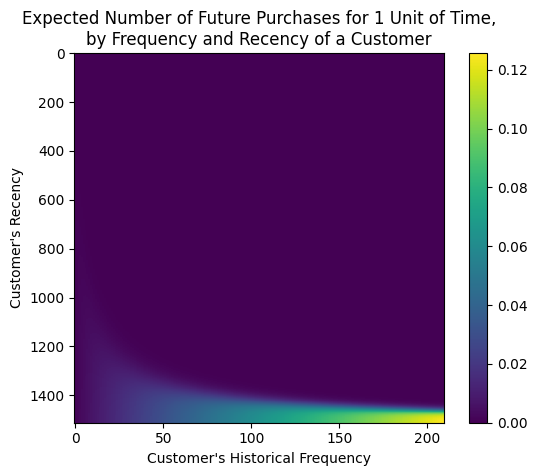

In [73]:
plot_frequency_recency_matrix(prod1_bgf)

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

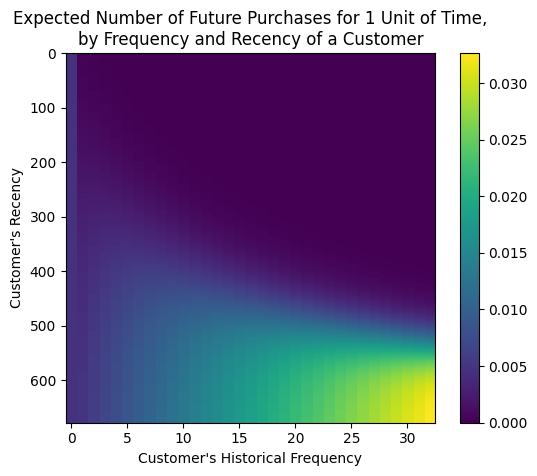

In [74]:
plot_frequency_recency_matrix(prod2_bgf)

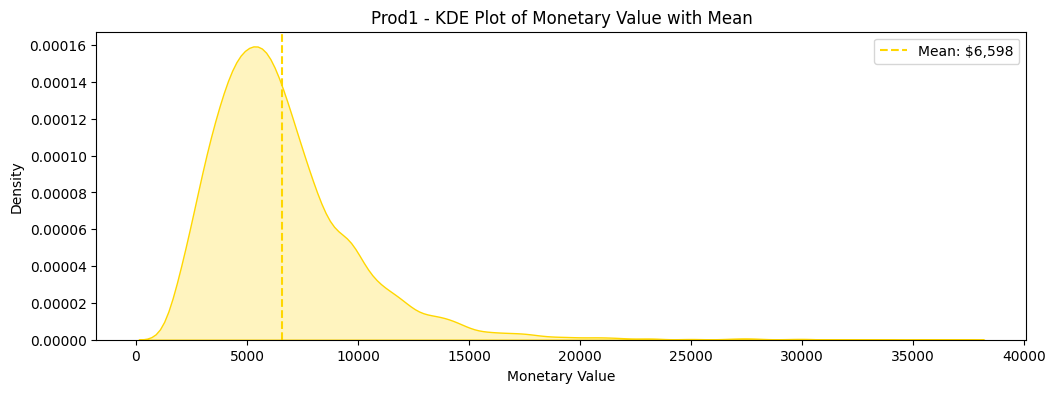

In [75]:
prod1_mean_value = prod1_clv_dataset['monetary_value'].mean()

plt.figure(figsize=(12,4))
sns.kdeplot(data=prod1_clv_dataset, x='monetary_value', fill=True, color='gold')

# Add a vertical line for the mean
plt.axvline(prod1_mean_value, color='gold', linestyle='--', label=f'Mean: ${prod1_mean_value:,.0f}')

plt.title('Prod1 - KDE Plot of Monetary Value with Mean')
plt.xlabel('Monetary Value')
plt.ylabel('Density')

# Display the legend
plt.legend()

# Show the plot
plt.show()

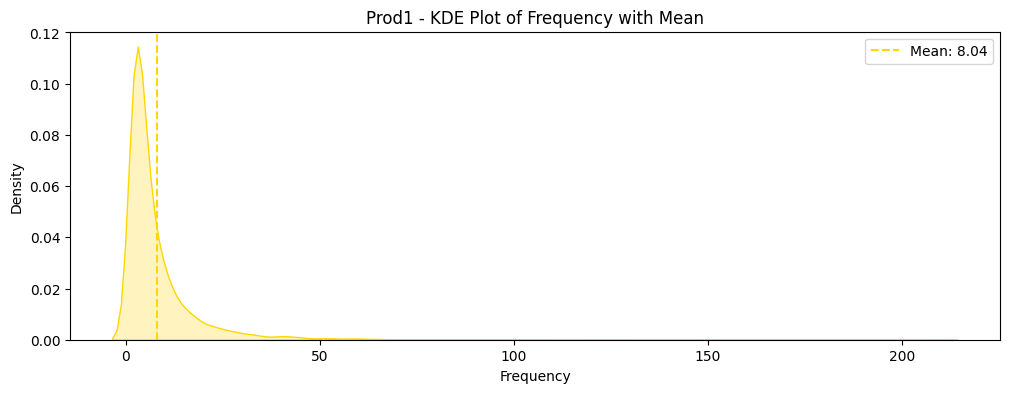

In [76]:
prod1_mean_value = prod1_clv_dataset['frequency'].mean()

plt.figure(figsize=(12,4))
sns.kdeplot(data=prod1_clv_dataset, x='frequency', fill=True, color='gold')

# Add a vertical line for the mean
plt.axvline(prod1_mean_value, color='gold', linestyle='--', label=f'Mean: {prod1_mean_value:,.2f}')

plt.title('Prod1 - KDE Plot of Frequency with Mean')
plt.xlabel('Frequency')
plt.ylabel('Density')

# Display the legend
plt.legend()

# Show the plot
plt.show()

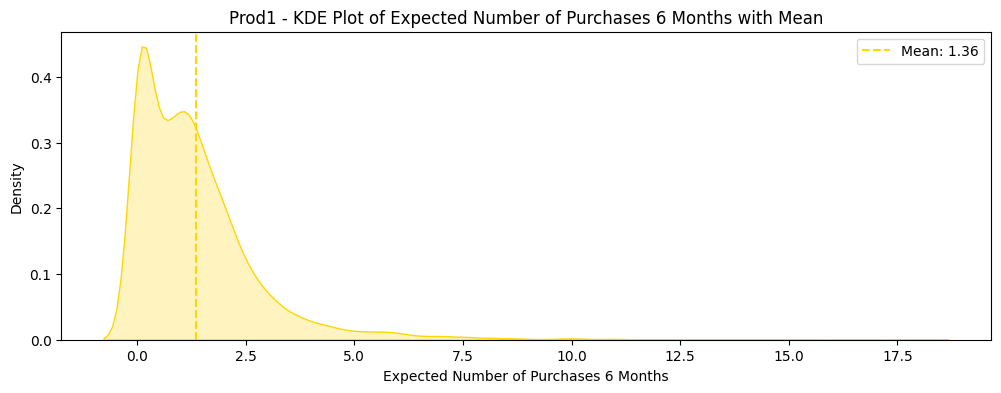

In [77]:
prod1_mean_value = prod1_clv_dataset['expected_num_purchases_6_months'].mean()

plt.figure(figsize=(12,4))
sns.kdeplot(data=prod1_clv_dataset, x='expected_num_purchases_6_months', fill=True, color='gold')

# Add a vertical line for the mean
plt.axvline(prod1_mean_value, color='gold', linestyle='--', label=f'Mean: {prod1_mean_value:,.2f}')

plt.title('Prod1 - KDE Plot of Expected Number of Purchases 6 Months with Mean')
plt.xlabel('Expected Number of Purchases 6 Months')
plt.ylabel('Density')

# Display the legend
plt.legend()

# Show the plot
plt.show()

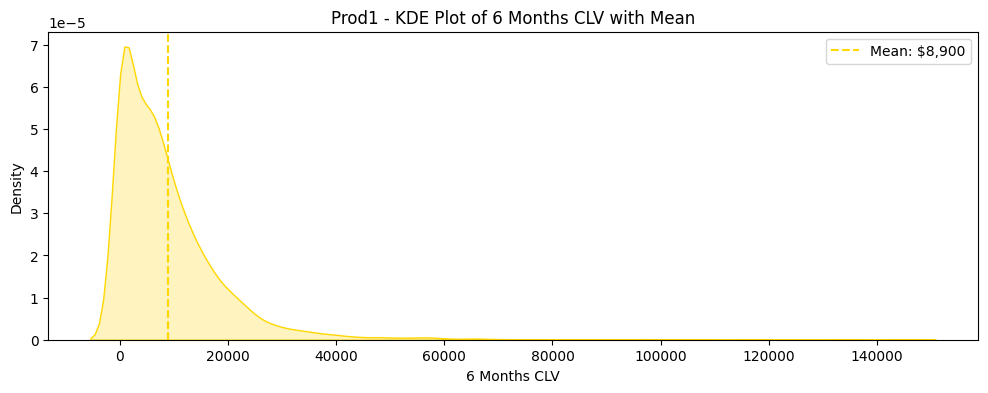

In [78]:
prod1_mean_value = prod1_clv_dataset['6_months_clv'].mean()

plt.figure(figsize=(12,4))
sns.kdeplot(data=prod1_clv_dataset, x='6_months_clv', fill=True, color='gold')

# Add a vertical line for the mean
plt.axvline(prod1_mean_value, color='gold', linestyle='--', label=f'Mean: ${prod1_mean_value:,.0f}')

plt.title('Prod1 - KDE Plot of 6 Months CLV with Mean')
plt.xlabel('6 Months CLV')
plt.ylabel('Density')

# Display the legend
plt.legend()

# Show the plot
plt.show()

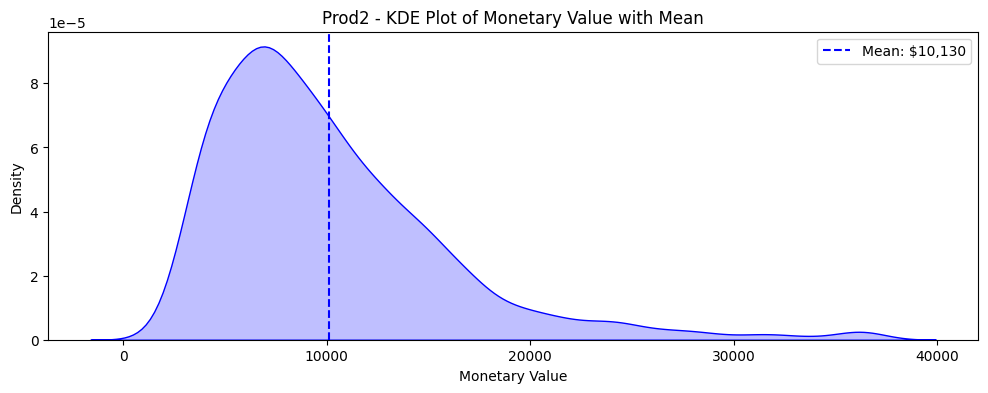

In [79]:
prod2_mean_value = prod2_clv_dataset['monetary_value'].mean()

plt.figure(figsize=(12,4))
sns.kdeplot(data=prod2_clv_dataset, x='monetary_value', fill=True, color='blue')

# Add a vertical line for the mean
plt.axvline(prod2_mean_value, color='blue', linestyle='--', label=f'Mean: ${prod2_mean_value:,.0f}')

plt.title('Prod2 - KDE Plot of Monetary Value with Mean')
plt.xlabel('Monetary Value')
plt.ylabel('Density')

# Display the legend
plt.legend()

# Show the plot
plt.show()

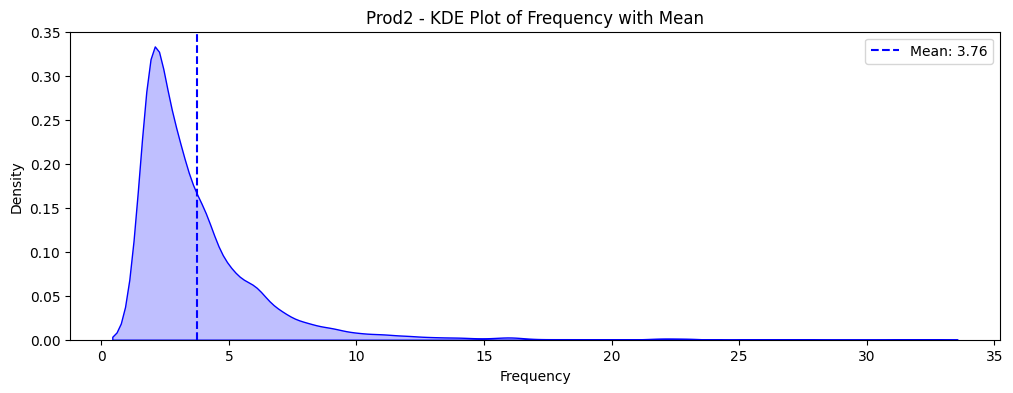

In [80]:
prod2_mean_value = prod2_clv_dataset['frequency'].mean()

plt.figure(figsize=(12,4))
sns.kdeplot(data=prod2_clv_dataset, x='frequency', fill=True, color='blue')

# Add a vertical line for the mean
plt.axvline(prod2_mean_value, color='blue', linestyle='--', label=f'Mean: {prod2_mean_value:,.2f}')

plt.title('Prod2 - KDE Plot of Frequency with Mean')
plt.xlabel('Frequency')
plt.ylabel('Density')

# Display the legend
plt.legend()

# Show the plot
plt.show()

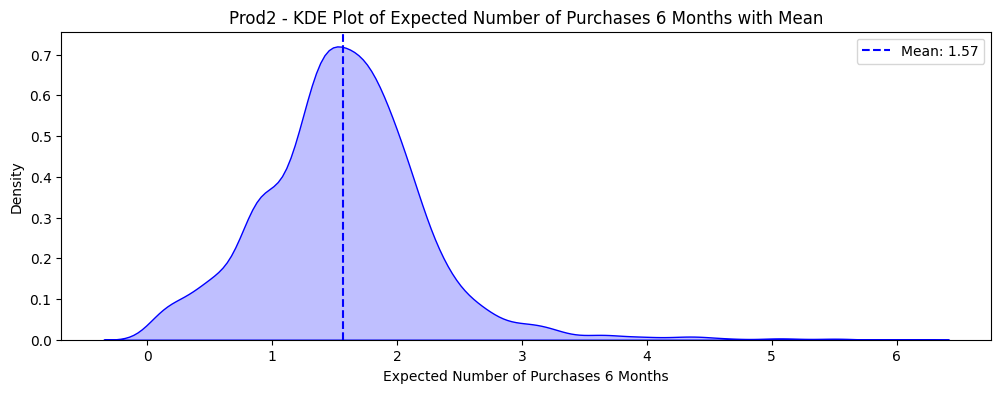

In [81]:
prod2_mean_value = prod2_clv_dataset['expected_num_purchases_6_months'].mean()

plt.figure(figsize=(12,4))
sns.kdeplot(data=prod2_clv_dataset, x='expected_num_purchases_6_months', fill=True, color='blue')

# Add a vertical line for the mean
plt.axvline(prod2_mean_value, color='blue', linestyle='--', label=f'Mean: {prod2_mean_value:,.2f}')

plt.title('Prod2 - KDE Plot of Expected Number of Purchases 6 Months with Mean')
plt.xlabel('Expected Number of Purchases 6 Months')
plt.ylabel('Density')

# Display the legend
plt.legend()

# Show the plot
plt.show()

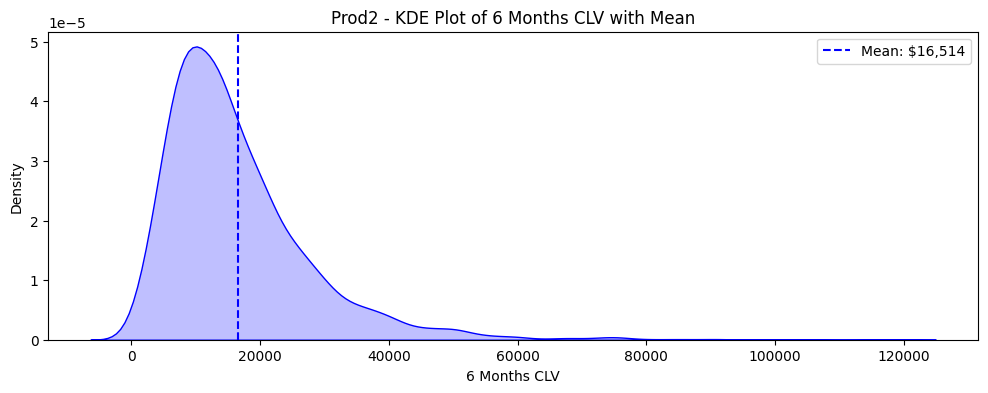

In [82]:
prod2_mean_value = prod2_clv_dataset['6_months_clv'].mean()

plt.figure(figsize=(12,4))
sns.kdeplot(data=prod2_clv_dataset, x='6_months_clv', fill=True, color='blue')

# Add a vertical line for the mean
plt.axvline(prod2_mean_value, color='blue', linestyle='--', label=f'Mean: ${prod2_mean_value:,.0f}')

plt.title('Prod2 - KDE Plot of 6 Months CLV with Mean')
plt.xlabel('6 Months CLV')
plt.ylabel('Density')

# Display the legend
plt.legend()

# Show the plot
plt.show()